## Importing libraries and datasets

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree

# Task 1

## a) Number of instances
There are 18846 instances in the dataset.

In [2]:
newsgroups = fetch_20newsgroups(subset='all')
print(len(newsgroups.data))

18846


## b) Classes
The dataset define 20 classes, the list is shown below.

In [3]:
tn = newsgroups.target_names
print("Classes:\n\t" + "\n\t".join(tn))
print("Number of classes: ", len(tn))

Classes:
	alt.atheism
	comp.graphics
	comp.os.ms-windows.misc
	comp.sys.ibm.pc.hardware
	comp.sys.mac.hardware
	comp.windows.x
	misc.forsale
	rec.autos
	rec.motorcycles
	rec.sport.baseball
	rec.sport.hockey
	sci.crypt
	sci.electronics
	sci.med
	sci.space
	soc.religion.christian
	talk.politics.guns
	talk.politics.mideast
	talk.politics.misc
	talk.religion.misc
Number of classes:  20


## c) Class distribution

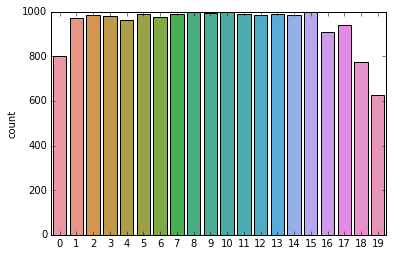

In [4]:
sns.countplot(newsgroups.target)
plt.show()

## d) Preventing overfitting
The texts begin with headers, which include email addresses and organisations, which can assist us a lot while searching for similarities between texts. But we want our machine lerning algorithm to decide on the topic only by looking at the contents of the texts since our test data might not include this additional information or it might be different from what we expected (for example, if people from the same organisation are having a discussion about cryptography but then somebody from them starts to talk about a hockey match, this should not be classified as the same class although this person belongs to the same organisation). Therefore we should remove this information.

In [5]:
newsgroups = fetch_20newsgroups(subset='all',
                                remove=('quotes','footers','headers'))

# Task 2
## a) Spitting the data

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    newsgroups.data,
    newsgroups.target,
    test_size=0.2,
    random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 15076
Test set size: 3770


## b) Class distribution in the test set

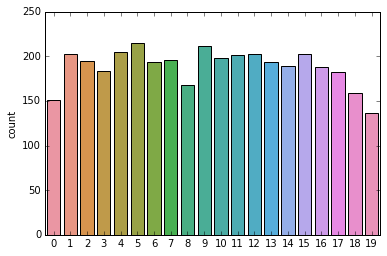

In [7]:
sns.countplot(Y_test)
plt.show()

The distribution of the test set doesn't differ too much from the distribution of the whole set.

# Task 3

## a) Number of attributes
We get 111584 attributes, which is way too much. The majority of the words appear only in a few (one, two, three) texts so they cannot help us to find similarities between texts. Furthermore, learning a decision tree on all these features would lead to a model that heavily overfits our training data.
Besides that, we should exclude words that appear many times, e. g. "and", "in", "or" and "the" since they probably tell nothing about the topic.

In [8]:
vectorizer = CountVectorizer()
X_features_train = vectorizer.fit_transform(X_train)
print("(#records, #features): ", X_features_train.shape)

(#records, #features):  (15076, 111584)


## b) Excluding words
If we exclude words that appear in less than three or more than half the texts, we get 30452 features.

In [9]:
vectorizer = CountVectorizer(max_df=0.5,min_df=3)
X_features_train = vectorizer.fit_transform(X_train)
print("(#records, #features): ", X_features_train.shape)

(#records, #features):  (15076, 30452)


# Task 4

## a) DecisionTreeClassifier
Here we create a decision tree provided by scikit-learn.

In [ ]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_features_train, Y_train)

## b) Number of nodes
Using the attribute node_count we get the number of nodes.

In [11]:
print(dt.tree_.node_count)

9449


## c) Accuracy (train set)
Decision tree's score() method returns the mean accuracy on the given test data and labels. The score with the training set is 97% which is good.

In [12]:
print(dt.score(X_features_train, Y_train))

0.973932077474


## d) Accuracy (test set)
With the test set we get only accuracy of 45%.

In [13]:
X_features_test=vectorizer.transform(X_test)
print(dt.score(X_features_test, Y_test))

0.454641909814


## e) Conclusion
Having a huge gap between the scores of the training set and the test set means that the model is overfitting to our train data. That means that the model doesn't generalize well and works only to recognize records in the training set.

However, the model is not so bad. If the classes were choosen randomly we would get a score of 5%. Having a test score of 45% is much better than that but still it isn't good.

# Task 5

## a) Adding feature selection

Using feature_selector.fit_transform to get only 10 most meaningful attribute (words that correlate with the class label) makes our decision tree much more simple. In part 4 our decision tree had around 9500 nodes and now it has only 213.

Also there is a dramatic change in the score for both training set and test set. Now both scores 12 % and 10 % are quite equal which is a good thing but on
the other hand they are both really bad. This indicates that the new model is underfitting. The result is was expected because the model is now using only 10 features and still trying to recognize 20 different newsgroups.

In [14]:
feature_selector = SelectKBest(chi2, k=10)
X_train_selected = feature_selector.fit_transform(X_features_train, Y_train)
X_test_selected = feature_selector.transform(X_features_test)

dt.fit(X_train_selected, Y_train)
print("Number of nodes:", dt.tree_.node_count)

print("Train set:", dt.score(X_train_selected, Y_train))
print("Test set:", dt.score(X_test_selected, Y_test))

Number of nodes: 213
Train set: 0.115415229504
Test set: 0.101326259947


## b) How not to find value for k
It is not a good idea to use test set for training because then the model is trained to work well on the test set. The point of the test set is to NOT use that part of the data for training, so it really should not be used.

Testing different k values is a good idea for finding an optimal amount of features used but we should not decide which one is the best according to the results on test data.

## c) Testing the method on training set
Using only the training set can easily lead to overfitting the training data. If we test the trees on the same data that the trees were trained on, we will probably get a very high accuracy.